In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import glob



/home/ubuntu/anaconda2/envs/carnd-advdl-odlab/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:

NUMBER_OF_CLASSES = 2
IMAGE_SHAPE = (160, 576)


EPOCHS = 30  # 1  # 2  # 20

BATCH_SIZE = 1

LEARNING_RATE = 0.0001
DROPOUT = 0.75

# Specify these directory paths

DATA_DIRECTORY = './data'
RUNS_DIRECTORY = './runs'
log_dir = './log'

TRAINING_DATA_DIRECTORY = './data/data_road/training'
NUMBER_OF_IMAGES = len(glob.glob('./data/data_road/training/calib/*.*'))
VGG_PATH = './data/vgg'

# Used for plotting to visualize if our training is going well given parameters
all_training_losses = []

In [3]:


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion(
    '1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn(
        'No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#----------

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


In [4]:

# need transform float into tensor !!
correct_label = tf.placeholder(
    tf.float32, [None, IMAGE_SHAPE[0], IMAGE_SHAPE[1], NUMBER_OF_CLASSES])
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)


In [5]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights

    model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

    graph = tf.get_default_graph()
    writer = tf.summary.FileWriter(log_dir, sess.graph)

    image_input = graph.get_tensor_by_name('image_input:0')

    keep_prob = graph.get_tensor_by_name('keep_prob:0')

    # pool1 = graph.get_tensor_by_name('pool1:0')
    # pool2 = graph.get_tensor_by_name('pool2:0')
    # pool3 = graph.get_tensor_by_name('pool3:0')
    # pool4 = graph.get_tensor_by_name('pool4:0')
    # pool5 = graph.get_tensor_by_name('pool5:0')

    layer3 = graph.get_tensor_by_name('layer3_out:0')
    layer4 = graph.get_tensor_by_name('layer4_out:0')
    layer7 = graph.get_tensor_by_name('layer7_out:0')

    # print("------------------")
    # print("shapes of layers:")
    # print("------------------")
#
    # print("pool1 -->", pool1.shape)
    # print("pool2 -->", pool2.shape)
    # print("pool3 -->", pool3.shape)
    # print("pool4 -->", pool4.shape)
    # print("pool5 -->", pool5.shape)
#
    # print("image_input -->", image_input.shape)
    # print("keep_prob -->", keep_prob.shape)
#
    # print("layer2 -->", layer2.shape)
    # print("layer3 -->", layer3.shape)
    # print("layer4 -->", layer4.shape)
    # print("layer5 -->", layer5.shape)
    # print("layer7 -->", layer7.shape)

    return image_input, keep_prob, layer3, layer4, layer7
tests.test_load_vgg(load_vgg, tf)


def conv_1x1(layer, layer_name):
    """ Return the output of a 1x1 convolution of a layer """
    return tf.layers.conv2d(inputs=layer,
                            filters=NUMBER_OF_CLASSES,
                            kernel_size=(1, 1),
                            strides=(1, 1),
                            # weights_initializer=custom_init
                            padding='same',
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(
                                1e-3),
                            name=layer_name)


def upsample(layer, k, s, layer_name):
    """ Return the output of transpose convolution given kernel_size k and strides s """
    # See:
    # http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#transposed-convolution-arithmetic
    return tf.layers.conv2d_transpose(inputs=layer,
                                      filters=NUMBER_OF_CLASSES,
                                      kernel_size=(k, k),
                                      strides=(s, s),
                                      padding='same',
                                      kernel_regularizer=tf.contrib.layers.l2_regularizer(
                                          1e-3),
                                      name=layer_name)


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function

    #---------------------------------- " regularization " ------------------------------#

    # output = tf.layers.dense(input, num_classes) ==>
    # output = tf.layers.conv2d(input, num_classes, 1, strides=(1,1))
    # conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1,
    # padding='same',
    # kernel_regularizer=tf.contib.layers.l2_regularizer(1e-3))

    # conv_1x1 to convolutional transpose: (batch_size, original_height, original_width, num_classes)
    # output = tf.layers.conv2d_transpose(input, num_classes, 4, strides=(2, 2))
    # output = tf.layers.conv2d_transpose(conv_1x1, num_classes, 4, 2,
    # padding='same',
    # kernel_regularizer=tf.contib.layers.l2_regularizer(1e-3))

    # vgg_layer3_out = tf.multiply(vgg_layer3_out, 0.0001)
    # vgg_layer4_out = tf.multiply(vgg_layer4_out, 0.01)

    # Apply a 1x1 convolution to encoder layers
    layer3x = conv_1x1(layer=vgg_layer3_out, layer_name="layer3conv1x1")
    layer4x = conv_1x1(layer=vgg_layer4_out, layer_name="layer4conv1x1")
    layer7x = conv_1x1(layer=vgg_layer7_out, layer_name="layer7conv1x1")

    tf.Print(layer3x, [tf.shape(layer3x)[1:3]])
    tf.Print(layer4x, [tf.shape(layer4x)[1:3]])
    tf.Print(layer7x, [tf.shape(layer7x)[1:3]])


    #---------------------------------- " deconvolution " ------------------------------#
    # formal tensorflow doc: ctrl + alt + w

    # filter: [filter_height, filter_width, out_channels, in_channels]
    # output = tf.nn.conv2d_transpose(conv_1x1, filter=tf.ones([? , ? , ?,
    # ?]), output_shape=[? , ? , ?, ?], strides=[1,2,2,1], padding='SAME')

    # skip connection: input: output of the current layer ; pool_4: output of a pooling layer further back
    # input = tf.add(input, pool_4) # shapes are the same!

    # add a print node
    # out.shape will get before TF runs ;  tf.shape only works if TF is running
    # tf.Print(output, [tf.shape(output)[1:3]])

    # Add decoder layers to the network with skip connections and upsampling
    # Note: the kernel size and strides are the same as the example in Udacity Lectures
    # Semantic Segmentation Scene Understanding Lesson 10-9: FCN-8 - Decoder


    # (1, 5, 18, 2) -> (1, 10, 36, 2)
    decoderlayer1 = upsample(layer=layer7x, k=4, s=2,
                             layer_name="decoderlayer1")
    print("decoderlayer1: upsample layer7x -->", decoderlayer1.shape)

    decoderlayer2 = tf.add(decoderlayer1, layer4x, name="decoderlayer2")
    print("decoderlayer2: decoderlayer1 + layer4x -->", decoderlayer2.shape)

    # (1, 10, 36, 2) ->   (1, 20, 72, 2)
    decoderlayer3 = upsample(layer=decoderlayer2, k=4,
                             s=2, layer_name="decoderlayer3")
    print("decoderlayer3: upsample decoderlayer2 -->", decoderlayer3.shape)

    decoderlayer4 = tf.add(decoderlayer3, layer3x, name="decoderlayer4")
    print("decoderlayer4: decoderlayer3 + layer3x -->", decoderlayer4.shape)

   # (1, 20, 72, 2) -> (1, 160, 576, 2)
    decoderlayer_output = upsample(
        layer=decoderlayer4, k=16, s=8, layer_name="decoderlayer_output")
    print("decoderlayer_output: upsample decoderlayer4 -->", decoderlayer_output.shape)

    print(type(decoderlayer_output))
    #return layer3, layer4, layer7, layer3x, layer4x, layer7x, decoderlayer1, decoderlayer2, decoderlayer3, decoderlayer4, decoderlayer_output
    return decoderlayer_output
tests.test_layers(layers)


def optimize(nn_last_layer, correct_label, learning_rate, num_classes=NUMBER_OF_CLASSES):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function

    print("--------optimize reshape----------")
    # 4D input reshape back to 2D , ( w, h, d, 2) --> ( w x h x d, 2)
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    print("logits type: ", type(logits))
    print("logits shape: ", logits.shape)

    # (?, w=160, h=576, 2) --> ( ? x w x h , 2)
    class_labels = tf.reshape(correct_label, (-1, num_classes))
    print("class_labels type: ", type(class_labels))
    print("class_labels shape: ", class_labels.shape)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=class_labels)
    print("cross_entropy type: ", type(cross_entropy))
    print("cross_entropy shape: ", cross_entropy.shape)

    cross_entropy_loss = tf.reduce_mean(cross_entropy)
    print("cross_entropy_loss type: ", type(cross_entropy_loss))
    print("cross_entropy_loss shape: ", cross_entropy_loss.shape)

    train_op = tf.train.AdamOptimizer(
        learning_rate).minimize(cross_entropy_loss)
    print("train_op type: ", type(train_op))

    return logits, train_op, cross_entropy_loss
tests.test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    print("--------train_nn----------")

    # TODO: Implement function

    for epoch in range(EPOCHS):

        losses, i = [], 0
        # loss_epoch, i = 0, 0

        for images, labels in get_batches_fn(BATCH_SIZE):

            # training
            i += 1

            # if learning_rate: LEARNING_RATE = 0.0001: 0.0001
            # TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a float into a Tensor
            # must remember  <tf.Tensor 'Placeholder_1:0' shape=<unknown>
            # dtype=float32>: 0.0001
            feed = {input_image: images,
                    correct_label: labels,
                    keep_prob: DROPOUT,
                    learning_rate: LEARNING_RATE}

            # print("feed= ", feed)
            # print(" feed type: ", type(feed))

            print("--------before sess.run----------")

            # https://github.com/tensorflow/tensorflow/blob/r1.5/tensorflow/python/client/session.py
            # https://www.tensorflow.org/api_docs/python/tf/Session#run
            # def run(self, fetches, feed_dict=None, options=None, run_metadata=None):
            # The value returned by run() has the same shape as the fetches
            # argument, where the leaves are replaced by the corresponding
            # values returned by TensorFlow
            _, partial_loss = sess.run(
                [train_op, cross_entropy_loss], feed_dict=feed)

            print("---> iteration: ", i, " partial loss:", partial_loss)

            tf.summary.scalar('partial loss', partial_loss)

            losses.append(partial_loss)
            # loss_epoch += partial_loss

        # loss_epoch = loss_epoch / i / 1.0
        training_loss = sum(losses) / len(losses)
        all_training_losses.append(training_loss)

        print("------------------")
        print("epoch: ", epoch + 1, " of ", EPOCHS,
              "training loss: ", training_loss)
        print("------------------")

tests.test_train_nn(train_nn)

# float: learning_rate ;  4D[batch, height, width, number_classes]: labels


Tests Passed
decoderlayer1: upsample layer7x --> (?, ?, ?, 2)
decoderlayer2: decoderlayer1 + layer4x --> (?, ?, ?, 2)
decoderlayer3: upsample decoderlayer2 --> (?, ?, ?, 2)
decoderlayer4: decoderlayer3 + layer3x --> (?, ?, ?, 2)
decoderlayer_output: upsample decoderlayer4 --> (?, ?, ?, 2)
<class 'tensorflow.python.framework.ops.Tensor'>
Tests Passed
--------optimize reshape----------
logits type:  <class 'tensorflow.python.framework.ops.Tensor'>
logits shape:  (24, 2)
class_labels type:  <class 'tensorflow.python.framework.ops.Tensor'>
class_labels shape:  (?, 2)
cross_entropy type:  <class 'tensorflow.python.framework.ops.Tensor'>
cross_entropy shape:  (24,)
cross_entropy_loss type:  <class 'tensorflow.python.framework.ops.Tensor'>
cross_entropy_loss shape:  ()
train_op type:  <class 'tensorflow.python.framework.ops.Operation'>
Tests Passed
INFO:tensorflow:Summary name partial loss is illegal; using partial_loss instead.
INFO:tensorflow:Summary name partial loss is illegal; using part

In [6]:


def run_tests():
    print("--------run_tests----------")

    tests.test_layers(layers)
    tests.test_optimize(optimize)
    tests.test_for_kitti_dataset(DATA_DIRECTORY)
    tests.test_train_nn(train_nn)


def run():

    print("--------run----------")

    data_dir = './data'
    runs_dir = './runs'

    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(
            data_dir, 'data_road/training'), image_shape=IMAGE_SHAPE)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function
        input_image, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(
            sess, vgg_path)

        layer_output = layers(layer3_out, layer4_out,
                              layer7_out, NUMBER_OF_CLASSES)

        # optimize
        logits, train_op, cross_entropy_loss = optimize(
            layer_output, correct_label, learning_rate, NUMBER_OF_CLASSES)

        # Initialize all variables
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # TODO: Train NN using the train_nn function
        train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op,
                 cross_entropy_loss, input_image, correct_label, keep_prob, learning_rate)

        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(
            runs_dir, data_dir, sess, IMAGE_SHAPE, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video, 30 images/s = 30
        # frames/s





In [ ]:
#if __name__ == '__main__':
#    # run_tests()
#    run()
#    print(all_training_losses)

In [11]:
import matplotlib.pyplot as plt
import scipy.misc

In [12]:
test_img = './data/lindau/42324078.jpg'
#gt_test_img = '/home/nike/dl/SDC/proj12/Semantic_Segmentation/data/leftImg8bit/gt_ds/aachen_000005_000019_gtFine_color.png'
img = scipy.misc.imread(test_img)
#gt_img = scipy.misc.imread(gt_test_img)
img.shape

/home/ubuntu/anaconda2/envs/carnd-advdl-odlab/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(768, 1024, 3)

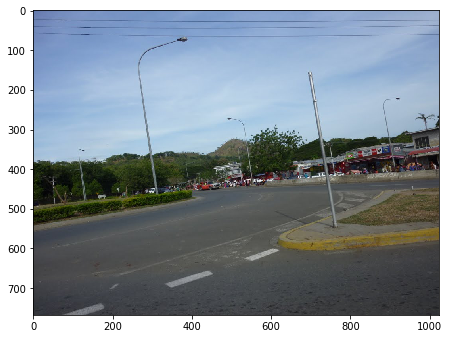

In [13]:

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img)
#plt.subplot(1,2,2)
#plt.imshow(gt_img)
plt.show()

In [ ]:
def showim(img):
    img_prep = np.concatenate((img, img, img), axis =2)
    plt.figure()
    plt.imshow(img_prep, cmap='gray')
    plt.show()

def showimg(img):
    plt.figure()
    plt.imshow(img)
    plt.show()

road_color = np.array([128, 64, 128, 255])
car_color = np.array([0, 0, 142, 255])
human_color = np.array([220, 20, 60, 255])
sign_color = np.array([220, 220, 0, 255])
#list(gt_img[490, :, 0])
gt_road = np.all(gt_img == road_color, axis=2)
gt_road = gt_road.reshape(*gt_road.shape, 1)
gt_road_int = gt_road.astype(np.uint8)*255
showim(gt_road_int)

gt_car = np.all(gt_img == car_color, axis=2)
gt_car = gt_car.reshape(*gt_car.shape, 1)
gt_car_int = gt_car.astype(np.uint8)*255
showim(gt_car_int)

gt_human = np.all(gt_img == human_color, axis=2)
gt_human = gt_human.reshape(*gt_human.shape, 1)
gt_human_int = gt_human.astype(np.uint8)*255
showim(gt_human_int)

gt_sign = np.all(gt_img == sign_color, axis=2)
gt_sign = gt_sign.reshape(*gt_sign.shape, 1)
gt_sign_int = gt_sign.astype(np.uint8)*255
showim(gt_sign_int)

gt_obj = np.concatenate((gt_road, gt_car, gt_human, gt_sign),axis=2)
gt_bg = np.all(gt_obj == 0, axis=2)
gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
gt_bg_int = gt_bg.astype(np.uint8)*255

gt_bg_int.shape
showim(gt_bg_int)

In [ ]:
import random
def bc_img(img, s = 1.0, m = 0):
    img = img * s + m
    
    img[img > 255] = 255
    img[img < 0] = 0
    img = img.astype(np.uint8)
    return img 

contr = random.uniform(0.8, 1.2) # Contrast augmentation
bright = random.randint(-20, 20) # Brightness augmentation
image = bc_img(img, contr, bright)
print(contr, bright)
print(np.max(img), np.min(img))
print(np.max(image), np.min(image))
showimg(image)